In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [3]:
df = pd.read_csv('../data/interim/preproc.csv', index_col=0)
df.head()

,key,project_id,creation_date,resolution_date,type,num_commits,lines_added,lines_removed,files_changed,duration,text,inter_text
0,EXEC-108,commons-exec,2018-09-18T11:15:58.000+0000,NaN,Bug,0,0,0,0,NaN,compatibility problem android adb using apache...,compatibility problem with android adb when us...
1,EXEC-107,commons-exec,2018-07-04T12:09:47.000+0000,NaN,New Feature,0,0,0,0,NaN,start independent process hi would like start ...,start independent process hi i would like to s...
2,EXEC-106,commons-exec,2018-03-06T11:32:51.000+0000,NaN,Improvement,0,0,0,0,NaN,watchdog class could use volatile instead sync...,watchdog class could use volatile instead of s...
3,EXEC-105,commons-exec,2018-02-16T13:47:10.000+0000,NaN,Wish,0,0,0,0,NaN,small mistake documentation apache common exec...,small mistakes in the documentation for apache...
4,EXEC-104,commons-exec,2017-08-04T11:57:39.000+0000,NaN,Bug,0,0,0,0,NaN,test failure watchdog killed process URL watch...,test failure 88 watchdog should have killed th...


## Preparing data

In [4]:
data_words = [str(txt).split(" ") for txt in df['text']]

# Latent Dirichlet Allocatin (LDA)
LDA is a topic modelling technique based on word probabilities. Check the [Wikipedia](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) page for more information.

In [5]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
import pickle 
import pyLDAvis

## TF Embedding

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 1), (2, 3), (3, 3), (4, 1), (5, 2), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1)]


In [6]:
#pickle.dump(id2word, open("idword.pkl", "wb"))

/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Compute optimal number of topics using the coherence measure

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Now:', num_topics)
        # Build LDA model
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# https://radimrehurek.com/gensim/models/coherencemodel.html
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=3, limit=24, step=2)

Now: 3


/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now: 5
Now: 7
Now: 9
Now: 11
Now: 13
Now: 15
Now: 17
Now: 19
Now: 21
Now: 23


## Train model with optimal value

In [7]:
#lda_model = model_list[np.argmax(coherence_values)]
num_topics = 11
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=12345)


/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'__.html')

/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## Count issues per topic

In [8]:
doc_topic = np.ones(len(corpus))
for i, document in enumerate(corpus):
    doc_topic[i] = int(np.argmax([x for _,x in lda_model.get_document_topics(document)]))+1

/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
from collections import Counter
d = dict(Counter(doc_topic))
ndocs = len(doc_topic)
{k:val/ndocs for k,val in d.items()}

/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{2.0: 0.25904455995970693,
 1.0: 0.4334546560358836,
 3.0: 0.14041756550000475,
 4.0: 0.059574832032994705,
 8.0: 0.038221402845223275,
 6.0: 0.027787016886979824,
 9.0: 0.003050489883967347,
 5.0: 0.0166779119824383,
 7.0: 0.0038867612540269317,
 10.0: 0.00827718594683975,
 11.0: 0.009607617671934543}

## Usage example

In [22]:
example = "problem connect database server access host URL".split(" ")
bow = id2word.doc2bow(example)
topic = int(np.argmax([x for _,x in lda_model.get_document_topics(document)]))+1
print(f'''The sentence: "{' '.join(example)}" 
is assigned to topic: {topic}''')

The sentence: "problem connect database server access host URL" 
is assigned to topic: 6


/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Statistical Tests

/Users/raulhigueras/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0.98, 'p-value of Mann-Whitney U test')

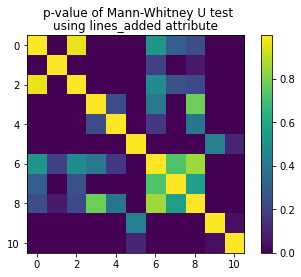

In [22]:
from scipy.stats import mannwhitneyu

df['topic'] = doc_topic
topics = set(doc_topic)
pvals = np.ones((11,11))
for i in range(11):
    for j in range(i+1):
        var1 = df[df['topic'] == i+1]['lines_added']
        var2 = df[df['topic'] == j+1]['lines_added']
        _, pval = mannwhitneyu(var1, var2, alternative='two-sided')
        pvals[i,j] = pvals[j,i] = pval

plt.imshow(pvals)
plt.colorbar();
plt.title("using lines_added attribute")
plt.suptitle("p-value of Mann-Whitney U test")
